# Revenue/Profit Calculations & RFM Customer Segmentation with K-Means Clustering

#### Data sources:
- https://drive.google.com/uc?export=download&id=1zXpZLlxvFVfiw3j73vnfTLDd1fouuPsM

#### Purpose:
- To explore and understand the sales database and its customers
- Carry out key accounting metrics calculations to assess this business' profitability
- Gain greater understanding of the customer base by carrying out an RFM segmentation
- Processing RFM scoring within K-means clustering

## Data Loading and Initial Exploration

#### Import libraries and load data

In [2]:
# Import libraries
import os
import scipy
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
# Label present working directory
pwd = os.getcwd()

# Load raw data
sales_data_original = pd.read_csv(pwd + "\\raw_data\sales_data.csv")

# Copy and visualise raw data
sdata = sales_data_original.copy()

sdata.head()

,OrderNumber,Sales Channel,WarehouseCode,ProcuredDate,OrderDate,ShipDate,DeliveryDate,CurrencyCode,_SalesTeamID,_CustomerID,_StoreID,_ProductID,Order Quantity,Discount Applied,Unit Price,Unit Cost
0,SO - 000101,In-Store,WARE-UHY1004,12/31/2017,5/31/2018,6/14/2018,6/19/2018,USD,6,15,259,12,5,0.075,1963.1,1001.181
1,SO - 000102,Online,WARE-NMK1003,12/31/2017,5/31/2018,6/22/2018,07/02/2018,USD,14,20,196,27,3,0.075,3939.6,3348.660
2,SO - 000103,Distributor,WARE-UHY1004,12/31/2017,5/31/2018,6/21/2018,07/01/2018,USD,21,16,213,16,1,0.050,1775.5,781.220
3,SO - 000104,Wholesale,WARE-NMK1003,12/31/2017,5/31/2018,06/02/2018,06/07/2018,USD,28,48,107,23,8,0.075,2324.9,1464.687
4,SO - 000105,Distributor,WARE-NMK1003,04/10/2018,5/31/2018,6/16/2018,6/26/2018,USD,22,49,111,26,8,0.100,1822.4,1476.144


In [4]:
# Change all Date columns to datetime format
date_cols = ["ProcuredDate", "OrderDate", "ShipDate", "DeliveryDate"]

for cols in date_cols:
    sdata[cols] = pd.to_datetime(sdata[cols]).dt.normalize()

# Ensure all date columns have been properly assigned
sdata.dtypes

OrderNumber                 object
Sales Channel               object
WarehouseCode               object
ProcuredDate        datetime64[ns]
OrderDate           datetime64[ns]
ShipDate            datetime64[ns]
DeliveryDate        datetime64[ns]
CurrencyCode                object
_SalesTeamID                 int64
_CustomerID                  int64
_StoreID                     int64
_ProductID                   int64
Order Quantity               int64
Discount Applied           float64
Unit Price                 float64
Unit Cost                  float64
dtype: object

## Calculate Profit for Each Individual Sale/Order

###### REVENUE per Order calculated as: "Unit Price" * "Order Quantity"

###### DISCOUNT per Order calculated as: ("Unit Price" * "Order Quantity") * "Discount Applied"

###### COSTS per Order calculated as: ("Unit Cost" * "Order Quantity")

###### PROFIT per Order calculated as: ("Revenue" - "Discount") - "Cost"

###### % PROFIT MARGIN per Order calculated as: ("Profit" / "Revenue") * 100

In [5]:
# REVENUE per Order calculations
sdata["RevenueperOrder"] = sdata["Unit Price"] * sdata["Order Quantity"]

# DISCOUNT per Order calculations
sdata["DiscountperOrder"] = (sdata["Unit Price"] * sdata["Order Quantity"]) * sdata["Discount Applied"]

# COSTS per Order calculations
sdata["CostsperOrder"] = sdata["Unit Cost"] * sdata["Order Quantity"]

# PROFIT per Order calculations
sdata["CalProfit"] = (sdata["RevenueperOrder"] - sdata["DiscountperOrder"]) - sdata["CostsperOrder"]

# PROFIT MARGIN per order calculations
sdata["%ProfitMargin"] = (sdata["CalProfit"] / sdata["RevenueperOrder"]) * 100

# Inspect calculated data columns
sdata.head()

,OrderNumber,Sales Channel,WarehouseCode,ProcuredDate,OrderDate,ShipDate,DeliveryDate,CurrencyCode,_SalesTeamID,_CustomerID,...,_ProductID,Order Quantity,Discount Applied,Unit Price,Unit Cost,RevenueperOrder,DiscountperOrder,CostsperOrder,CalProfit,%ProfitMargin
0,SO - 000101,In-Store,WARE-UHY1004,2017-12-31,2018-05-31,2018-06-14,2018-06-19,USD,6,15,...,12,5,0.075,1963.1,1001.181,9815.5,736.1625,5005.905,4073.4325,41.5
1,SO - 000102,Online,WARE-NMK1003,2017-12-31,2018-05-31,2018-06-22,2018-07-02,USD,14,20,...,27,3,0.075,3939.6,3348.660,11818.8,886.4100,10045.980,886.4100,7.5
2,SO - 000103,Distributor,WARE-UHY1004,2017-12-31,2018-05-31,2018-06-21,2018-07-01,USD,21,16,...,16,1,0.050,1775.5,781.220,1775.5,88.7750,781.220,905.5050,51.0
3,SO - 000104,Wholesale,WARE-NMK1003,2017-12-31,2018-05-31,2018-06-02,2018-06-07,USD,28,48,...,23,8,0.075,2324.9,1464.687,18599.2,1394.9400,11717.496,5486.7640,29.5
4,SO - 000105,Distributor,WARE-NMK1003,2018-04-10,2018-05-31,2018-06-16,2018-06-26,USD,22,49,...,26,8,0.100,1822.4,1476.144,14579.2,1457.9200,11809.152,1312.1280,9.0


#### Calculate proportion of profitable to unprofitable sales, and total resulting monetary loss

In [6]:
# Calculate total number of unprofitable orders
unporfitable_orders_total = sdata[sdata["%ProfitMargin"] <= 0]["OrderNumber"].nunique()

total_orders = sdata["OrderNumber"].nunique()

perc_unprofitable_orders = (unporfitable_orders_total / total_orders) * 100

print("Of all sales, only " + str(round(perc_unprofitable_orders, 2)) + " % were unprofitable")

Of all sales, only 4.98 % were unprofitable


In [7]:
# Calculate total profit loss from unprofitable orders
profit_loss = round(sdata[sdata["CalProfit"] <= 0]["CalProfit"].sum(), 2)

# Calculate total profits
total_profits = round(sdata[sdata["%ProfitMargin"] > 0]["CalProfit"].sum(), 2)

# Print results
print("In total, profit loss from all unprofitable orders equates to " + str(profit_loss) + " USD")
print("Total sales profits over the same time period was " + str(total_profits) + " USD")
print("Lost profits therefore represent " + str(round((profit_loss / total_profits) * 100, 2)) + " % of total profits")

In total, profit loss from all unprofitable orders equates to -346229.94 USD
Total sales profits over the same time period was 21671557.09 USD
Lost profits therefore represent -1.6 % of total profits


## Customer Segementation

#### Calculate Recency, Frequency, Monetary (R/F/M) Segmentation

In [8]:
# Switch '_CustomerID' column from int64 to Object
sdata['_CustomerID'] = sdata['_CustomerID'].apply(lambda x: str(x))

print(sdata.dtypes)

OrderNumber                 object
Sales Channel               object
WarehouseCode               object
ProcuredDate        datetime64[ns]
OrderDate           datetime64[ns]
ShipDate            datetime64[ns]
DeliveryDate        datetime64[ns]
CurrencyCode                object
_SalesTeamID                 int64
_CustomerID                 object
_StoreID                     int64
_ProductID                   int64
Order Quantity               int64
Discount Applied           float64
Unit Price                 float64
Unit Cost                  float64
RevenueperOrder            float64
DiscountperOrder           float64
CostsperOrder              float64
CalProfit                  float64
%ProfitMargin              float64
dtype: object


In [9]:
# Select columns of interest and create RFM data
cols = ["OrderNumber", "_CustomerID", "OrderDate", "CalProfit"]
data_rfm = sdata[cols]

# Set today's date
today = pd.to_datetime("2021-01-01")    # Dataset finishes end of 2020, so 'today' would be early in 2021

# Calculate RFM per customer ID
rfm_results = data_rfm.groupby("_CustomerID").agg(
    {"OrderDate": lambda v: (today - v.max()).days,     # Calculate RECENCY
     "OrderNumber": "count",                            # Calculate FREQUENCY
     "CalProfit": "sum"}                                # Calculate MONETARY
).reset_index()

# Inspect data
rfm_results.head()

,_CustomerID,OrderDate,OrderNumber,CalProfit
0,1,9,152,335933.6115
1,10,15,158,435122.1870
2,11,6,178,487614.2415
3,12,3,210,616719.2550
4,13,4,171,441003.2795


In [10]:
# Assign score between 1 and 5 for R, F and M
r = pd.qcut(rfm_results["OrderDate"], q=5, labels=range(5,0,-1))    # Here require higher score for lowest number of days since last purchase, so turn range around
f = pd.qcut(rfm_results["OrderNumber"], q=5, labels=range(1,6))     # Here range is normal way around, as lower no of orders = low score
m = pd.qcut(rfm_results["CalProfit"], q=5, labels=range(1,6))

# Segment rfm_results with respect to quantiles
rfm_segmentation = rfm_results.assign(R=r.values, F=f.values, M=m.values)

print(rfm_segmentation.head())

  _CustomerID  OrderDate  OrderNumber    CalProfit  R  F  M
0           1          9          152  335933.6115  2  2  1
1          10         15          158  435122.1870  1  3  3
2          11          6          178  487614.2415  3  5  5
3          12          3          210  616719.2550  5  5  5
4          13          4          171  441003.2795  4  4  3


In [11]:
# Add column summarising each of R, F, M columns into single descriptive column
rfm_segmentation["RFM_summary"] = rfm_segmentation[["R", "F", "M"]].apply(lambda c: "-".join(c.astype(str)), axis=1)

# Add column synthesising RFM segmentation as single metric
rfm_segmentation["RFM_score"] = rfm_segmentation[["R", "F", "M"]].sum(axis=1)

# Drop individual R, F and M columns
rfm_final = rfm_segmentation.drop(columns=["R", "F", "M"])

# Visualise final RFM segmentation
rfm_final.head()

,_CustomerID,OrderDate,OrderNumber,CalProfit,RFM_summary,RFM_score
0,1,9,152,335933.6115,2-2-1,5
1,10,15,158,435122.1870,1-3-3,7
2,11,6,178,487614.2415,3-5-5,13
3,12,3,210,616719.2550,5-5-5,15
4,13,4,171,441003.2795,4-4-3,11


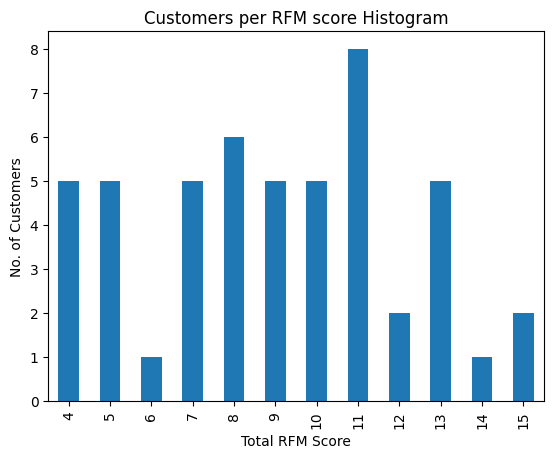

In [24]:
# Count number of customers per RFM score
rfm_numbers = rfm_final["RFM_score"].value_counts().reset_index().sort_values(by="RFM_score")

# Visualise RFM scores
rfm_numbers.plot(x="RFM_score", y="count", kind="bar", legend=False)

plt.title("Customers per RFM score Histogram")
plt.xlabel("Total RFM Score")
plt.ylabel("No. of Customers")

plt.show()

##### Analysis suggests splitting customer base in 3 segments:
 - Segment 1: RFM scores 4-6 (inclusive) - represent low-priority customers --> 11 total customers in segment
 - Segment 2: RFM scores 7-11 (inclusive) - represent mid-priority customers --> 29 total customers in segment 
 - Segment 3: RFM scores 12-15 (inclusive) - represent high-priority customers --> 10 total customers in segment

#### Applying K-means clustering

In [13]:
# Use:
print(rfm_segmentation.head())

# Select data
X = rfm_segmentation.iloc[:, 4:7].values

  _CustomerID  OrderDate  OrderNumber    CalProfit  R  F  M RFM_summary  \
0           1          9          152  335933.6115  2  2  1       2-2-1   
1          10         15          158  435122.1870  1  3  3       1-3-3   
2          11          6          178  487614.2415  3  5  5       3-5-5   
3          12          3          210  616719.2550  5  5  5       5-5-5   
4          13          4          171  441003.2795  4  4  3       4-4-3   

   RFM_score  
0          5  
1          7  
2         13  
3         15  
4         11  


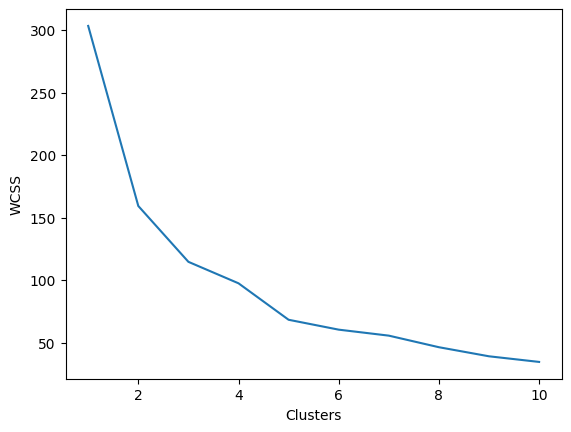

In [14]:
# Import KMeans library
from sklearn.cluster import KMeans

# Calculate Within Clusters Sum of Squares (WCSS) for multiple K-means clusterings
wcss = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init="k-means++", random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# Plot elbow curve
plt.plot(np.arange(1,11), wcss)
plt.xlabel("Clusters")
plt.ylabel("WCSS")
           
plt.show()

- K-means clustering validation also points to 2, or more likely 3 clusters within the data (where curve appears to change slope the most).

In [15]:
# Apply optimum k-means clustering
kmeans_optimum = KMeans(n_clusters=3, init="k-means++", random_state=42)

# Fit and assign cluster number for each customer
y = kmeans_optimum.fit_predict(X)
print(y)

[0 0 1 1 1 0 2 2 1 1 1 0 1 1 2 1 0 1 0 2 0 1 1 1 2 1 1 1 0 2 0 0 1 1 0 2 2
 0 2 2 2 1 1 0 1 1 2 2 0 1]


In [16]:
# Add cluster labels to each customer
rfm_final["clustering_id"] = y

# Inspect data
rfm_final.head(31)

,_CustomerID,OrderDate,OrderNumber,CalProfit,RFM_summary,RFM_score,clustering_id
0,1,9,152,335933.6115,2-2-1,5,0
1,10,15,158,435122.1870,1-3-3,7,0
2,11,6,178,487614.2415,3-5-5,13,1
3,12,3,210,616719.2550,5-5-5,15,1
4,13,4,171,441003.2795,4-4-3,11,1
5,14,5,157,381450.0280,3-3-2,8,0
6,15,4,142,441668.3550,4-1-4,9,2
7,16,3,135,402938.7705,5-1-2,8,2
8,17,6,175,534027.3860,3-5-5,13,1
9,18,6,186,451637.7540,3-5-4,12,1


#### Clustered data analysis and exploration

In [17]:
# How many customers per cluster?
rfm_final["clustering_id"].value_counts()

clustering_id
1    23
0    14
2    13
Name: count, dtype: int64

- Very close customer number per cluster as those crudely predicted above.

clustering_id
1    477485.708761
2    399542.326615
0    367793.257679
Name: CalProfit, dtype: float64


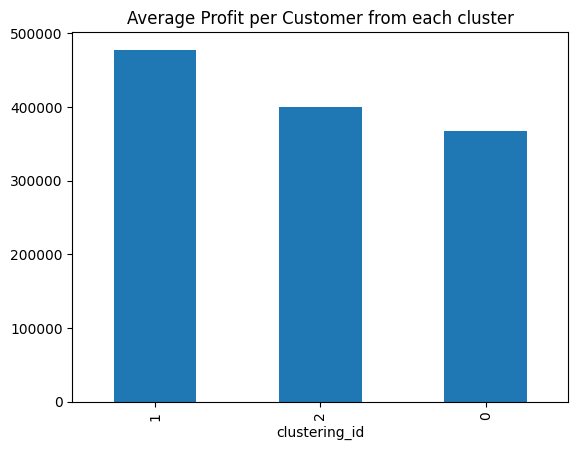

In [18]:
# What is the average profit per customer in each cluster?
cluster_avg_profits = rfm_final.groupby("clustering_id")["CalProfit"].mean().sort_values(ascending=False)
print(cluster_avg_profits)

cluster_avg_profits.plot(kind="bar")

plt.title("Average Profit per Customer from each cluster")

plt.show()

- Cluster 1 customers gnerated approximately 20% more in overall Profits compared to clusters 0 and 2.
- There is only about a 10% difference in Profits generated between cluster groups 0 and 2, which cluster 2 showing the slight advantage.

clustering_id
1    11.565217
2     8.538462
0     5.214286
Name: RFM_score, dtype: float64


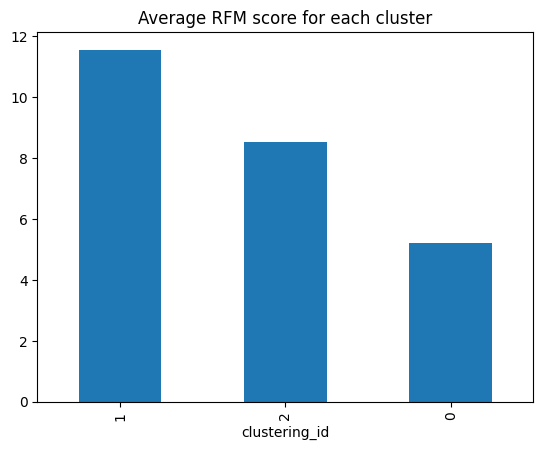

In [19]:
# Calculate average cluster RFM score
cluster_avg_rfm = rfm_final.groupby("clustering_id")["RFM_score"].mean().sort_values(ascending=False)
print(cluster_avg_rfm)

# Visualise results
cluster_avg_rfm.plot(kind="bar")

plt.title("Average RFM score for each cluster")

plt.show()

- Cluster 1 customers average RFM_scores above 10 (11.56), characterised by high recency, frequency and monetary amounts - these are our *core/regular customers*.
- Cluster 2 customers average RFM_scores around 8 (8.53), characterised by often high recency but low freq & monetary amounts - which may represent *newly acquired customers*.
- Cluster 0 customers average RFM_scores below 6 (5.21), characterised by all around low  recency, freq & monetary amounts - these are most probably *occasional, single-sale or disgruntled customers*.

In [20]:
# Add clustering_id column to RFM_segmentation
rfm_segmentation["clustering_id"] = y

# Isolate each customer cluster
cluster0 = rfm_segmentation[rfm_segmentation.clustering_id == 0]
cluster1 = rfm_segmentation[rfm_segmentation.clustering_id == 1]
cluster2 = rfm_segmentation[rfm_segmentation.clustering_id == 2]

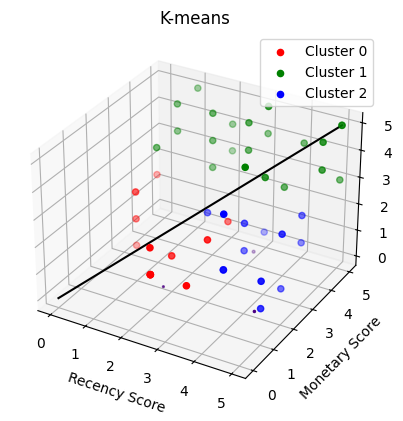

In [21]:
# Visualise the three clusters on a 3D graph
kplot = plt.axes(projection="3d")

xline = np.linspace(0, 5, 500)
yline = np.linspace(0, 5, 500)
zline = np.linspace(0, 5, 500)

kplot.plot3D(xline, yline, zline, 'black')

# Plot data on 3D graph
kplot.scatter3D(cluster0.R, cluster0.F, cluster0.M, c="red", label="Cluster 0")
kplot.scatter3D(cluster1.R, cluster1.F, cluster1.M, c="green", label="Cluster 1")
kplot.scatter3D(cluster2.R, cluster2.F, cluster2.M, c="blue", label="Cluster 2")

plt.scatter(kmeans_optimum.cluster_centers_[:,0], kmeans_optimum.cluster_centers_[:,1], kmeans_optimum.cluster_centers_[:,2],
            color="indigo")

plt.ylabel("Monetary Score")
plt.xlabel("Recency Score")
plt.title("K-means")
plt.legend()

plt.show()

In [22]:
# Validate clustering model using Silhouette score
from sklearn.metrics import silhouette_score

score = silhouette_score(X,y)
print(score)

0.3689498627996152


## Customer Lifetime Value Calculations

###### Total Customer Value = sum("CalProfit")

###### Average Customer Lifespan = Latest OrderDate - Earliest OrderDate

###### Customer lifetime value = total customer value x average customer lifespan

In [23]:
# Calculate metrics for customer lifetime value
clv = sdata.groupby("_CustomerID").agg(
    {"OrderDate": lambda v: (v.max() - v.min()).days,       # Calculate Average Customer Lifespan
     "CalProfit": "sum"}                                    # Calculate Total Customer Value
).reset_index()

# Calculate CLV metric for each customer
clv["CLV"] = clv["CalProfit"] * clv["OrderDate"]

# Inspect results
clv.describe()

,OrderDate,CalProfit,CLV
count,50.000000,50.000000,5.000000e+01
mean,933.360000,426506.543100,3.981033e+08
std,8.188494,61829.500149,5.792246e+07
min,908.000000,327409.134500,3.058001e+08
25%,930.250000,379173.552250,3.568023e+08
50%,935.000000,431140.896250,4.033104e+08
75%,939.750000,459110.934000,4.268484e+08
max,943.000000,616719.255000,5.729322e+08
